<a href="https://colab.research.google.com/github/yasminemejrissi/dashbord-ecommerce/blob/main/projet_KPI_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install faker
!pip install pymongo
!pip install matplotlib
!pip install pandas
!pip install streamlit

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from faker import Faker
import datetime
import streamlit as st
from config import uri_mongo

from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
client = MongoClient(uri_mongo, server_api=ServerApi('1'))

In [3]:
fake=Faker()
client=MongoClient(uri_mongo, server_api=ServerApi('1'))
db=client["ecommerce"]
clients_col=db["clients"]
commandes_col=db["commandes"]

In [4]:
clients_col.delete_many({})
commandes_col.delete_many({})

DeleteResult({'n': 2000, 'electionId': ObjectId('7fffffff0000000000000038'), 'opTime': {'ts': Timestamp(1746500162, 220), 't': 56}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1746500162, 220), 'signature': {'hash': b'\xab\xa7\xacz]\xa7\xcb\x92\x8aP\xad\x1bA\x12\n@\xbf*\x13\xfe', 'keyId': 7464295776219299841}}, 'operationTime': Timestamp(1746500162, 220)}, acknowledged=True)

In [5]:
produits=[
    {"nom":"T-shirt","catégorie":"Vêtements","prix":20},
    {"nom":"Jean","catégorie":"Vêtements","prix":45},
    {"nom":"Basket","catégorie":"Chaussures","prix":70},
    {"nom":"Bracelet","catégorie":"Accessoires","prix":18},
    {"nom":"Collier","catégorie":"Accessoires","prix":25},
    {"nom":"Sac à main", "catégorie":"Bagagerie", "prix":20},
    {"nom":"Sac à dos", "catégorie":"Bagagerie", "prix":30},
    {"nom":"Montre", "catégorie":"Accessoires", "prix":90},
    {"nom":"Full Korean skincare", "catégorie":"Beauté", "prix":120},
    {"nom":"Chargeur", "catégorie":"Informatique","prix":15},

]

In [6]:
#Generate and insert 100 fake clients into the database
clients=[]
for i in range(100):
  client={
  "nom":fake.last_name(),
  "prenom":fake.first_name(),
  "adresse":fake.address(),
  "ville":fake.city(),
  "code_postal":fake.postcode(),
  "pays":fake.country(),
  "email":fake.email(),
  "telephone":fake.phone_number(),
  }
  client_id=clients_col.insert_one(client).inserted_id
  clients.append({"_id": client_id, **client})


commandes=[]
moyen_paiement=["Carte bancaire", "Paypal", "Virement", "Apple Pay"]
code_promo=[None,"WELCOME10","SALES20","FREESHIP"]

# Generate 2000 fake orders
for i in range(2000):
  client=random.choice(clients)
  nb_produits=random.randint(1, len(produits))
  produit_commande=[]
  montant_totale=0
  for j in range(nb_produits):
    produit=random.choice(produits)
    quantite= random.randint(1,5)
    prix=produit["prix"]
    montant=round(prix*quantite,2)
    produit_commande.append({
        "nom":produit["nom"],
        "prix_unitaire":prix,
        "quantite":quantite,
        "montant":montant
    })
    montant_totale+=montant
  date=fake.date_between(start_date='-6M', end_date='today')
  commande={
      "client_id":client["_id"],
      "date":date.isoformat(),
      "email":client["email"],
      "pays":client["pays"],
      "produits":produit_commande,
      "moyen_paiement":random.choice(moyen_paiement),
      "code_promo":random.choice(code_promo),
      "montant_totale":montant_totale

  }
  commandes.append(commande)

# Insert all orders into the database
commandes_col.insert_many(commandes)

#Print first 3 orders for verification

for doc in commandes_col.find().limit(3):
   print(doc)

{'_id': ObjectId('68197a4d7345ee31c7de66d6'), 'client_id': ObjectId('68197a4c7345ee31c7de66c3'), 'date': '2024-11-20', 'email': 'zbowen@example.com', 'pays': 'Puerto Rico', 'produits': [{'nom': 'Chargeur', 'prix_unitaire': 15, 'quantite': 1, 'montant': 15}, {'nom': 'Full Korean skincare', 'prix_unitaire': 120, 'quantite': 3, 'montant': 360}, {'nom': 'Collier', 'prix_unitaire': 25, 'quantite': 5, 'montant': 125}, {'nom': 'T-shirt', 'prix_unitaire': 20, 'quantite': 5, 'montant': 100}, {'nom': 'Bracelet', 'prix_unitaire': 18, 'quantite': 3, 'montant': 54}, {'nom': 'Chargeur', 'prix_unitaire': 15, 'quantite': 4, 'montant': 60}, {'nom': 'Collier', 'prix_unitaire': 25, 'quantite': 2, 'montant': 50}, {'nom': 'Full Korean skincare', 'prix_unitaire': 120, 'quantite': 3, 'montant': 360}, {'nom': 'Jean', 'prix_unitaire': 45, 'quantite': 3, 'montant': 135}, {'nom': 'Collier', 'prix_unitaire': 25, 'quantite': 3, 'montant': 75}], 'moyen_paiement': 'Paypal', 'code_promo': None, 'montant_totale': 1334

In [7]:
#KPIs
#Chiffres d'affaires
#Total revenue and order count by country

pipeline = [
    {
        "$group": {
            "_id": "$pays",
            "chiffre_affaires": { "$sum": "$montant_totale" },
            "nb_commandes": { "$sum": 1 }
        }
    },
    {
        "$sort": { "chiffre_affaires": -1 }
    }
]

resultat = list(commandes_col.aggregate(pipeline))

for doc in resultat:
    print(f"{doc['_id']} : {round(doc['chiffre_affaires'], 2)} € sur {doc['nb_commandes']} commandes.")

Indonesia : 58088 € sur 73 commandes.
Papua New Guinea : 52236 € sur 65 commandes.
Madagascar : 44539 € sur 58 commandes.
Timor-Leste : 42153 € sur 52 commandes.
Anguilla : 39901 € sur 57 commandes.
Slovakia (Slovak Republic) : 32946 € sur 44 commandes.
Tajikistan : 32507 € sur 41 commandes.
New Caledonia : 30867 € sur 47 commandes.
Spain : 30011 € sur 39 commandes.
Romania : 29694 € sur 40 commandes.
Switzerland : 29030 € sur 31 commandes.
British Indian Ocean Territory (Chagos Archipelago) : 28505 € sur 36 commandes.
Chile : 27577 € sur 38 commandes.
Algeria : 26791 € sur 30 commandes.
Israel : 23876 € sur 29 commandes.
Saint Kitts and Nevis : 23290 € sur 38 commandes.
Greece : 23063 € sur 28 commandes.
Mozambique : 21141 € sur 27 commandes.
Hungary : 21095 € sur 26 commandes.
Comoros : 20806 € sur 24 commandes.
Martinique : 20284 € sur 24 commandes.
Sudan : 20200 € sur 25 commandes.
Botswana : 19380 € sur 23 commandes.
United States of America : 19069 € sur 21 commandes.
Turks and C

Indonesia : 58088 € sur 73 commandes
Papua New Guinea : 52236 € sur 65 commandes
Madagascar : 44539 € sur 58 commandes
Timor-Leste : 42153 € sur 52 commandes
Anguilla : 39901 € sur 57 commandes
Slovakia (Slovak Republic) : 32946 € sur 44 commandes
Tajikistan : 32507 € sur 41 commandes
New Caledonia : 30867 € sur 47 commandes
Spain : 30011 € sur 39 commandes
Romania : 29694 € sur 40 commandes
Switzerland : 29030 € sur 31 commandes
British Indian Ocean Territory (Chagos Archipelago) : 28505 € sur 36 commandes
Chile : 27577 € sur 38 commandes
Algeria : 26791 € sur 30 commandes
Israel : 23876 € sur 29 commandes
Saint Kitts and Nevis : 23290 € sur 38 commandes
Greece : 23063 € sur 28 commandes
Mozambique : 21141 € sur 27 commandes
Hungary : 21095 € sur 26 commandes
Comoros : 20806 € sur 24 commandes
Martinique : 20284 € sur 24 commandes
Sudan : 20200 € sur 25 commandes
Botswana : 19380 € sur 23 commandes
United States of America : 19069 € sur 21 commandes
Turks and Caicos Islands : 18866 € 

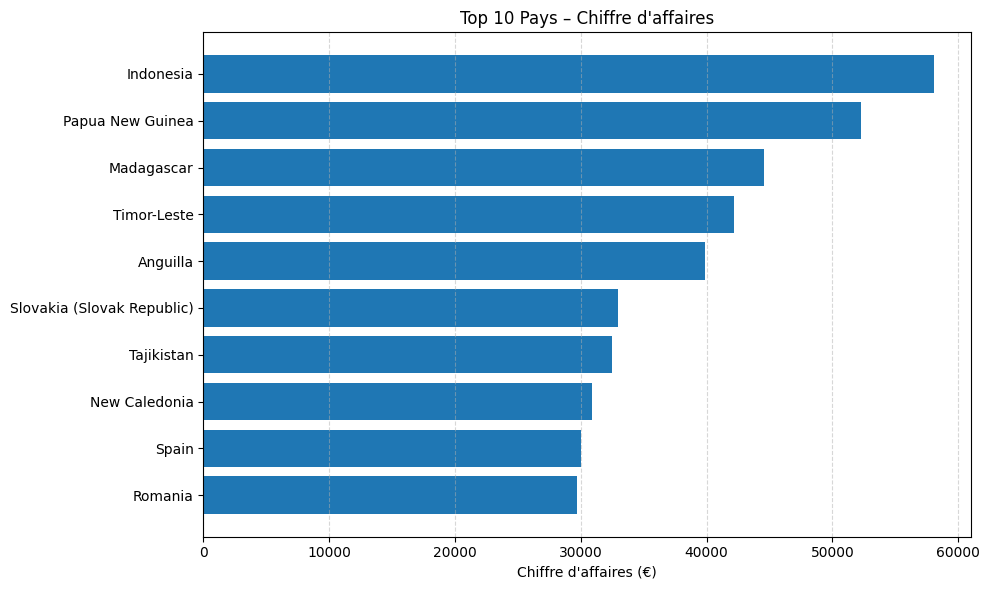

In [8]:
#Agrégation MongoDB – KPI Chiffre d'affaires par pays
#Total revenue and order count by country
pipeline = [
    {
        "$group": {
            "_id": "$pays",
            "chiffre_affaires": { "$sum": "$montant_totale" },
            "nb_commandes": { "$sum": 1 }
        }
    },
    {
        "$sort": { "chiffre_affaires": -1 }
    }
]

resultat = list(commandes_col.aggregate(pipeline))

for doc in resultat:
    print(f"{doc['_id']} : {round(doc['chiffre_affaires'], 2)} € sur {doc['nb_commandes']} commandes")

#Data visualization with matplotlib
pays = [doc["_id"] for doc in resultat[:10]]
ca = [doc["chiffre_affaires"] for doc in resultat[:10]]

plt.figure(figsize=(10,6))
plt.barh(pays[::-1], ca[::-1])
plt.xlabel("Chiffre d'affaires (€)")
plt.title("Top 10 Pays – Chiffre d'affaires")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
#Top 10 customer

pipeline=[
    {
        "$group":{
            "_id":"$client_id",
            "montant_total":{"$sum":"$montant_totale"},
            "nb_commandes":{"$sum":1}
        }
    },
    {
        "$sort":{"montant_total":-1}
    },
    {"$limit":10},
    {
        "$lookup":{
            "from":"clients",
            "localField":"_id",
            "foreignField":"_id",
            "as":"client"
    }},
    {"$unwind":"$client"},
    {"$project":{
        "nom":"$client.nom",
        "prenom":"$client.prenom",
        "email": "$client.email",
        "adresse":"$client.adresse",
        "ville":"$client.ville",
        "pays":"$client.pays",
        "chiffre_affaires":"$montant_total",
        "nb_commandes":"$nb_commandes"
    }}
]
top_clients=list(commandes_col.aggregate(pipeline))
for client in top_clients:
  print(f"{client['nom']} {client['prenom']} ({client['email']}) - {client['adresse']}, {client['ville']}, {client['pays']} - {round(client['chiffre_affaires'],2)} EUR sur {client['nb_commandes']} commandes.")


Parrish Theresa (valenzuelaalexander@example.com) - 446 Troy Loaf
Joshuaburgh, KY 66489, Lake Davidmouth, Indonesia - 28274 EUR sur 34 commandes.
Chandler Todd (robinsontonya@example.net) - 69708 Garcia Plains Suite 543
Grossburgh, MD 24177, East Cynthialand, Anguilla - 26800 EUR sur 36 commandes.
Gonzalez Mike (tallen@example.com) - 5406 Taylor Mountains Suite 806
Josephberg, MN 07772, New Nancyborough, Greece - 23063 EUR sur 28 commandes.
Stephens Derek (xstevens@example.net) - USS Lozano
FPO AA 22229, Port Ryanshire, Madagascar - 22884 EUR sur 32 commandes.
Benjamin Andrea (gibbsjennifer@example.net) - 741 Joel Turnpike Apt. 236
Judymouth, PA 47641, South Kevin, Madagascar - 21655 EUR sur 26 commandes.
Little David (kyle15@example.com) - PSC 8052, Box 6021
APO AP 02600, South David, Mozambique - 21141 EUR sur 27 commandes.
Chaney Joshua (lisahernandez@example.org) - 00410 Neal Ridges
South Sheri, LA 74303, Salazarberg, Hungary - 21095 EUR sur 26 commandes.
Solis Sandra (tmiller@exam

In [10]:
#panier moyen
#Average basket value

pipeline=[
    {
          "$group":{
              "_id":None,
              "total_montant":{"$sum":"$montant_totale"},
              "total_commandes":{"$sum":1}
          }
      },
      {
          "$project":{
              "_id":0,
              "panier_moyen":{"$divide": ["$total_montant","$total_commandes"]
              },
              "total_montant":1,
              "total_commandes":1
          }
      }
]

resultat = list(commandes_col.aggregate(pipeline))

if resultat:
    panier_moyen = round(resultat[0]["panier_moyen"], 2)
    print(f"Le panier moyen est : {panier_moyen} EUR")
else:
    print("Aucune commande trouvée.")

Le panier moyen est : 751.53 EUR


2024-11 : 324 commandes - 243092 EUR - panier moyen 750.28
2024-12 : 329 commandes - 241506 EUR - panier moyen 734.06
2025-01 : 321 commandes - 249781 EUR - panier moyen 778.13
2025-02 : 342 commandes - 264682 EUR - panier moyen 773.92
2025-03 : 324 commandes - 232788 EUR - panier moyen 718.48
2025-04 : 314 commandes - 230911 EUR - panier moyen 735.39
2025-05 : 46 commandes - 40301 EUR - panier moyen 876.11


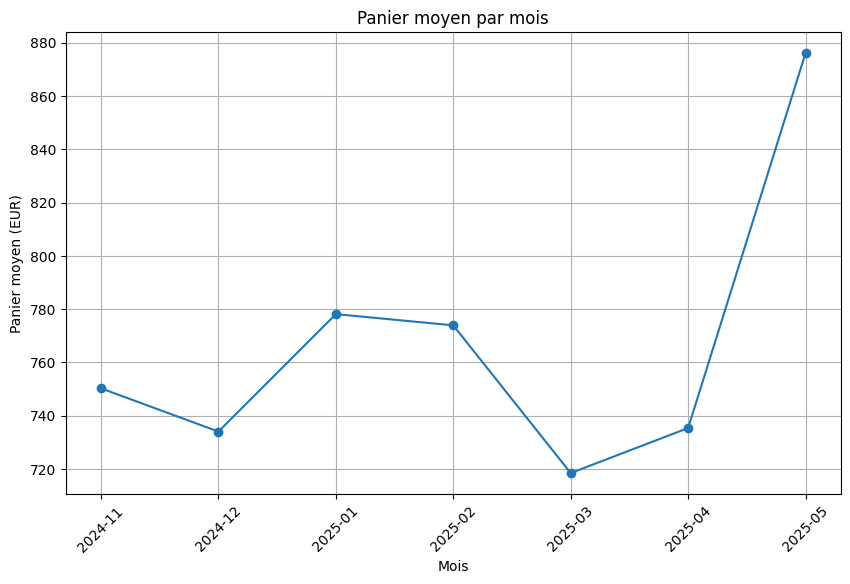

In [11]:
#Panier moyen par mois
# Average basket value per month

pipeline=[
    {
        "$group":{
            "_id": {"$substr":["$date",0,7]},
            "nb_commandes": {"$sum":1},
            "chiffre_affaires":{"$sum":"$montant_totale"},
        }
    },
    {
        "$project":{
            "nb_commandes":1,
            "chiffre_affaires":1,
            "panier_moyen":{"$divide":["$chiffre_affaires","$nb_commandes"]}
        }
    },
    {
        "$sort":{"_id":1}
    }
]
resultat=list(commandes_col.aggregate(pipeline))
for ligne in resultat:
  print(f"{ligne['_id']} : {ligne['nb_commandes']} commandes - {round(ligne['chiffre_affaires'],2)} EUR - panier moyen {round(ligne['panier_moyen'],2)}")

# Plot average basket value over time
df_panier_mensuel = pd.DataFrame(resultat)
df_panier_mensuel.rename(columns={"_id": "mois"}, inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(df_panier_mensuel["mois"], df_panier_mensuel["panier_moyen"], marker='o', linestyle='-')
plt.xlabel("Mois")
plt.ylabel("Panier moyen (EUR)")
plt.title("Panier moyen par mois")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [12]:
# Customer behavioral segmentation
# Build a full client profiling based on purchasing behavior:
# - Identify valuable customers
# - Understand buying habits
# - Create meaningful segments (e.g., VIP, promo addict)
# - Prepare data for future ML models or business dashboards

pipeline = [
    {
        "$group": {
            "_id": "$client_id",
            "chiffre_affaires": { "$sum": "$montant_totale" },
            "nb_commandes": { "$sum": 1 },
            "nb_commandes_promos": {
                "$sum": {
                    "$cond": [ { "$ne": ["$code_promo", None] }, 1, 0 ]  # Count 1 if promo code is used
                }
            }
        }
    },
    {
        "$project": {
            "nb_commandes": 1,
            "chiffre_affaires": 1,
            "code_promo": 1,
            "panier_moyen": {
                "$round": [ { "$divide": ["$chiffre_affaires", "$nb_commandes"] }, 2 ]
            },
            "ratio_code_promos": {
                "$round": [ { "$divide": ["$nb_commandes_promos", "$nb_commandes"] }, 2 ]
            }
        }
    },
    {
        "$lookup": {
            "from": "clients",
            "localField": "_id",
            "foreignField": "_id",
            "as": "client"
        }
    },
    {
        "$unwind": "$client"
    },
    {
        "$project": {
            "client_id": "$_id",
            "nom": "$client.nom",
            "prenom": "$client.prenom",
            "pays": "$client.pays",
            "email": "$client.email",
            "chiffre_affaires": 1,
            "nb_commandes": 1,
            "panier_moyen": 1,
            "ratio_code_promos": 1
        }
    }
]

# Load the result into a DataFrame
resultat = list(commandes_col.aggregate(pipeline))
df_comportement = pd.DataFrame(resultat)

# Select relevant columns
colonnes = [
    "client_id", "nom", "prenom", "pays", "email",
    "chiffre_affaires", "nb_commandes", "panier_moyen", "ratio_code_promos"
]
df = df_comportement[colonnes]

# Display summary statistics
print(df["chiffre_affaires"].describe())
print(df["nb_commandes"].describe())
print(df["panier_moyen"].describe())
print(df["ratio_code_promos"].describe())


count      100.000000
mean     15030.610000
std       3896.154532
min       6104.000000
25%      12555.000000
50%      14758.000000
75%      17210.250000
max      28274.000000
Name: chiffre_affaires, dtype: float64
count    100.00000
mean      20.00000
std        4.65149
min        9.00000
25%       17.00000
50%       19.00000
75%       23.00000
max       36.00000
Name: nb_commandes, dtype: float64
count     100.000000
mean      752.698900
std       102.196548
min       488.410000
25%       686.030000
50%       745.355000
75%       824.222500
max      1002.330000
Name: panier_moyen, dtype: float64
count    100.000000
mean       0.742300
std        0.102916
min        0.500000
25%        0.670000
50%        0.740000
75%        0.820000
max        1.000000
Name: ratio_code_promos, dtype: float64


In [13]:
# Assign customer profiles based on behavior
def profiler(row):
    if row["chiffre_affaires"] >= 17000 and row["nb_commandes"] >= 28:
        return "VIP"
    if row["ratio_code_promos"] >= 0.8 and row["nb_commandes"] >= 24:
        return "Promo addict"
    if row["nb_commandes"] >= 20:
        return "Regulier"
    else:
        return "Occasionel"

df["profil"] = df.apply(profiler, axis=1)

# Display the first 10 customer profiles
df.head(10)


,client_id,nom,prenom,pays,email,chiffre_affaires,nb_commandes,panier_moyen,ratio_code_promos,profil
0,68197a4b7345ee31c7de66b7,Mccarthy,Pamela,Netherlands,wlane@example.com,16453,23,715.35,0.70,Regulier
1,68197a497345ee31c7de66a9,Gray,April,Liechtenstein,shannon89@example.com,11613,17,683.12,0.76,Occasionel
2,68197a477345ee31c7de6692,Stafford,James,South Africa,john58@example.com,15632,20,781.60,0.80,Regulier
3,68197a497345ee31c7de66a1,Gonzalez,Mike,Greece,tallen@example.com,23063,28,823.68,0.61,VIP
4,68197a4c7345ee31c7de66c7,Wilson,Gregory,Brunei Darussalam,chrissparks@example.net,13565,19,713.95,0.89,Occasionel
5,68197a4c7345ee31c7de66c9,Yates,Mary,Australia,taylortony@example.net,10500,17,617.65,0.82,Occasionel
6,68197a497345ee31c7de66a8,Little,David,Mozambique,kyle15@example.com,21141,27,783.00,0.67,Regulier
7,68197a4d7345ee31c7de66ce,Bell,Abigail,Romania,davidknight@example.net,10136,16,633.50,0.88,Occasionel
8,68197a457345ee31c7de6678,Colon,Derrick,Gabon,hartjacob@example.org,11490,18,638.33,0.67,Occasionel
9,68197a4a7345ee31c7de66ae,Quinn,Michael,Spain,bryanwheeler@example.com,11289,15,752.60,0.60,Occasionel


In [14]:
print(df["profil"].value_counts())


profil
Occasionel      52
Regulier        39
VIP              5
Promo addict     4
Name: count, dtype: int64


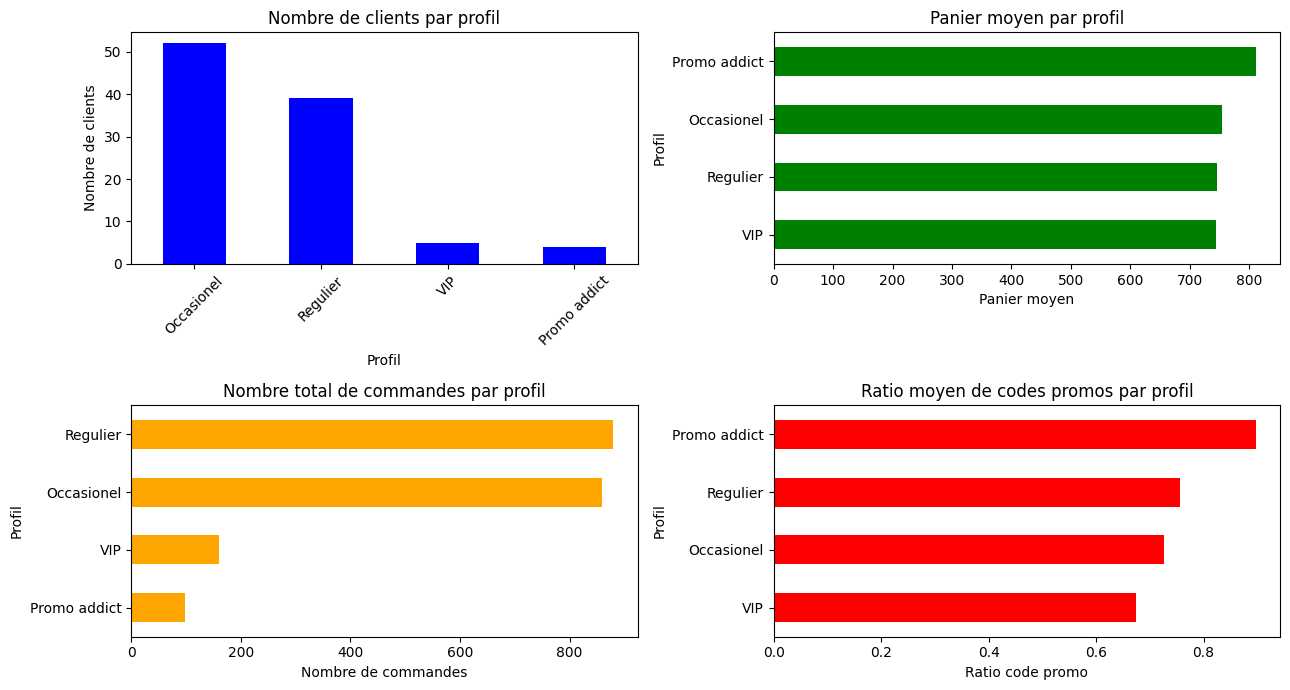

In [15]:
# Customer segmentation dashboard with matplotlib

# Create a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(13, 7))

# Number of clients per profile
df["profil"].value_counts().plot(kind="bar", color="blue", ax=axes[0, 0])
axes[0, 0].set_title("Nombre de clients par profil")
axes[0, 0].set_xlabel("Profil")
axes[0, 0].set_ylabel("Nombre de clients")
axes[0, 0].tick_params(axis='x', rotation=45)

# Average basket value per profile
df.groupby("profil")["panier_moyen"].mean().sort_values().plot(kind="barh", color="green", ax=axes[0, 1])
axes[0, 1].set_title("Panier moyen par profil")
axes[0, 1].set_xlabel("Panier moyen")
axes[0, 1].set_ylabel("Profil")

# Total number of orders per profile
df.groupby("profil")["nb_commandes"].sum().sort_values().plot(kind="barh", color="orange", ax=axes[1, 0])
axes[1, 0].set_title("Nombre total de commandes par profil")
axes[1, 0].set_xlabel("Nombre de commandes")
axes[1, 0].set_ylabel("Profil")

# Average promo code usage ratio per profile
df.groupby("profil")["ratio_code_promos"].mean().sort_values().plot(kind="barh", color="red", ax=axes[1, 1])
axes[1, 1].set_title("Ratio moyen de codes promos par profil")
axes[1, 1].set_xlabel("Ratio code promo")
axes[1, 1].set_ylabel("Profil")

plt.tight_layout()
plt.show()


In [16]:
# Export customer dashboard data to CSV
df.to_csv("dashboard_clients.csv", index=False)